In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy
from google.colab import files
%matplotlib inline

uploaded = files.upload()

Saving ex2data1.txt to ex2data1.txt


### 2.1 Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams.
* You have historical data from previous applicants that you can use as a training set for logistic regression.
* For each training example, you have the applicant’s scores on two exams and the admissions decision.
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.

In [26]:
data = np.loadtxt("ex2data1.txt", delimiter=",")

X_train = data[:, :2]
y_train = data[:, 2]

In [27]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


In [28]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0. 0. 0. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [29]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


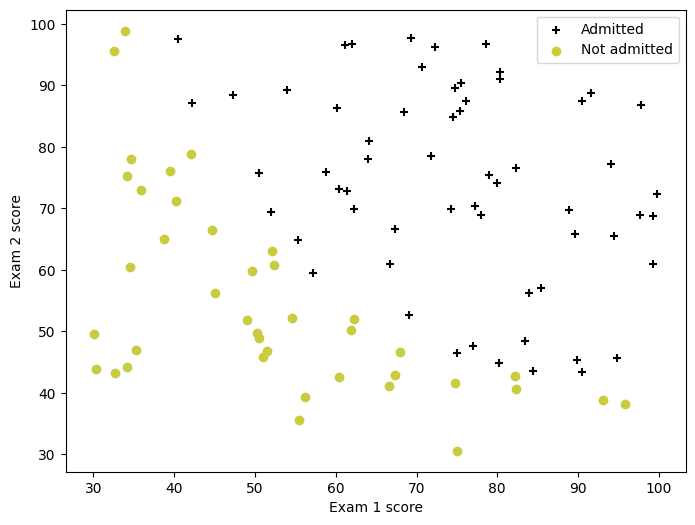

In [30]:
# Separate admitted and not admitted students
admitted = data[y_train == 1]
not_admitted = data[y_train == 0]

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(admitted[:, 0], admitted[:, 1], marker='+', color='black', label="Admitted")
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], marker='o', color='#C9CC3F', label="Not admitted")

# Labels and legend
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend()
plt.show()

The formula for a sigmoid function is as follows:
$$g(z) = \frac{1}{1+e^{-z}} \tag{1}$$

In [31]:
def sigmoid(z):

    g = 1 / (1 + np.exp(-z))

    return g


The Cost Function is defined as:

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{2}$$

where
* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{3}$$
* m is the number of training examples in the dataset and:
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.

In [32]:
def compute_cost(X, y, w, b, *argv):

    m, n = X.shape
    loss_sum = 0

    for i in range(m):

        z_wb = 0
        for j in range(n):

            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij

        z_wb += b
        f_wb = sigmoid(z_wb)

        loss = (-y[i] * np.log(f_wb)) - (1 - y[i]) * np.log(1 - f_wb)

        loss_sum += loss

    total_cost = (1 / m) * loss_sum

    return total_cost

The Gradient is defined as:
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{4}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{5}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label

In [33]:
def compute_gradient(X, y, w, b, *argv):

    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = 0
        for j in range(n):
            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij
        z_wb += b
        f_wb = sigmoid(z_wb)

        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i

        for j in range(n):
            dj_dw_ij = (f_wb - y[i]) * X[i][j]
            dj_dw[j] += dj_dw_ij

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

Gradient Descent is defined as:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{6}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

In [34]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):

    m = len(X)
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [35]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


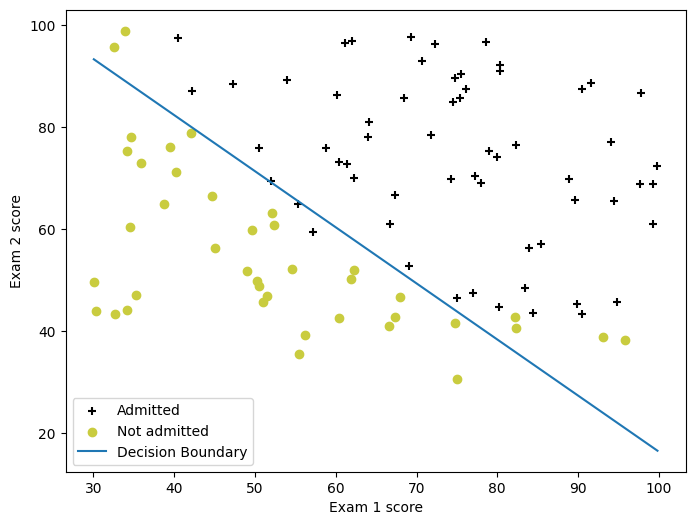

In [36]:
# Plot the data points
admitted = data[y_train == 1]
not_admitted = data[y_train == 0]

plt.figure(figsize=(8, 6))
plt.scatter(admitted[:, 0], admitted[:, 1], marker='+', color='black', label="Admitted")
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], marker='o', color='#C9CC3F', label="Not admitted")

# Plot the decision boundary
x_values = [np.min(X_train[:, 0]), np.max(X_train[:, 0])]
y_values = - (w[0] / w[1]) * np.array(x_values) - (b / w[1])

plt.plot(x_values, y_values, label="Decision Boundary")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend()
plt.show()

**Evaluating Logistic Regression**


*   if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
*   if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$


  


In [37]:
def predict(X, w, b):

    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    # Loop over each example
    for i in range(m):
        z_wb = 0
        # Loop over each feature
        for j in range(n):
            # Add the corresponding term to z_wb
            z_wb_ij = w[j] * X[i][j]
            z_wb += z_wb_ij

        # Add bias term
        z_wb += b

        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = f_wb >= 0.5

    return p

In [38]:
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3

tmp_X2 = np.array([[0.70, -0.85],
                    [-1.30, 0.00],
                    [0.25, 0.80],
                    [-0.60, -1.10]])



tmp_p = predict(tmp_X2, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

Output of predict: shape (4,), value [1. 0. 1. 0.]


In [39]:
#Computing accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000
